In [1]:
import dask.dataframe as dd
import dask_geopandas
import numpy as np

In [2]:
# import coiled

# coiled.create_software_environment(
#      account="coiled-examples",
#      name="spatial-join",
#      conda="environment.yml",
# )

# Performing Spatial Joins in Python
This blog explains how to perform a spatial join in Python. Knowing how to perform a spatial join is an important asset in your data-processing toolkit: it enables you to join two datasets based on spatial predicates. For example, you can join points to polygons they are located within, join points located outside a certain radius from another point, or join lines that intersect.

In this blog we will use the New York City Taxi and Limousine Commission dataset to illustrate performing a spatial join in Python. We will join the taxi pickup location of each individual trip record to the NYC neighborhood it is located within. This will then allow us to bring in public health data at the neighborhood level and discover interesting patterns in the data that we could not have seen without if we had not performed a spatial join.

Spatial joins are powerful because they allow you to merge various datasets based on location.

## Spatial Join: Different Python Libraries
There are different ways to perform a spatial join in Python. This blog will walk you through the 3 most popular libraries you can use to perform spatial joins: 
1. Geopandas
2. Spatialpandas
3. Dask-Geopandas

For each library, we will first demonstrate and explain the syntax, and then tell you when and why you should use it.

Let’s jump in.

## Spatial Join: Geopandas
GeoPandas is an extension of the pandas DataFrame, designed to make it easier to work with geospatial data directly from Python, instead of using a dedicated  spatial database such as PostGI.

A GeoPandas GeoDataFrame looks and feels a lot like a regular pandas DataFrame. The main difference is that it has a geometry column that contains shapely geometries. This column is what will enable us to perform a spatial join.

Let’s load in the NYC TLC data. We’ll start by working with 1 month of data:

In [16]:
import pandas as pd

# read in raw 2009 data
df = pd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-01.csv",
    nrows=100_000,
)

Let's inspect the first three rows of this dataset:

In [17]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2012-01-10 23:55:50,2012-01-11 00:03:39,1,1.7,-73.994693,40.725031,1,N,-73.975951,40.730781,CRD,6.9,0.5,0.5,1.00,0.0,8.90
1,CMT,2012-01-11 19:18:25,2012-01-11 19:26:10,1,1.1,-73.987955,40.752947,1,N,-73.994532,40.761040,CSH,6.1,1.0,0.5,0.00,0.0,7.60
2,CMT,2012-01-11 19:19:19,2012-01-11 19:48:15,2,18.0,-73.783093,40.648550,2,N,-73.996134,40.747624,CRD,45.0,0.0,0.5,10.06,4.8,60.36
3,CMT,2012-01-11 19:19:21,2012-01-11 19:27:00,1,1.7,-73.967515,40.758454,1,N,-73.956583,40.779903,CRD,6.9,1.0,0.5,1.00,0.0,9.40
4,CMT,2012-01-11 14:38:15,2012-01-11 14:43:51,1,1.2,-74.011315,40.711449,1,N,-74.002872,40.728131,CSH,5.7,0.0,0.5,0.00,0.0,6.20


Next, let’s read in our geographic data. This is a dataset sourced from the NYC Department of Health and contains the shapely geometries of XX New York neighbourhoods. We’ll load this into a GeoPandas GeoDataFrame:

In [18]:
import geopandas as gpd

# read in neighbourhood polygons
ngbhoods = gpd.read_file(
    "/Users/rpelgrim/Desktop/data/nyc/nyc-communityhealth-shapefiles/CHS_2009_DOHMH_2010B/CHS_2009_DOHMH_2010B.shp",
)[["geometry", "FIRST_UHF_", "UHF_CODE"]]

Let’s inspect what kind of object this is and take a look at the first 3 rows:

In [19]:
type(ngbhoods)

geopandas.geodataframe.GeoDataFrame

In [20]:
len(ngbhoods)

35

In [21]:
ngbhoods.head(3)

,geometry,FIRST_UHF_,UHF_CODE
0,"POLYGON ((1017992.893 269222.964, 1017812.000 ...",Kingsbridge - Riverdale,101.0
1,"POLYGON ((1025012.990 270794.260, 1025061.481 ...",Northeast Bronx,102.0
2,"POLYGON ((1023994.479 261065.967, 1023885.806 ...",Fordham - Bronx Park,103.0


ngbhoods is a GeoPandas GeoDataFrame containing the shapely polygons that define the 35 New York neighborhoods, as well as their names and unique ID codes.

A neat trick to know about GeoPandas is that calling .plot() on a GeoDataFrame will automatically plot the geometries of the shapes contained:

<AxesSubplot:>

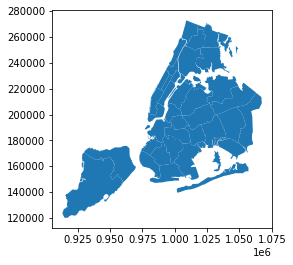

In [22]:
ngbhoods.plot()

Before you proceed, you’ll want to cast this to the correct Coordinate Reference System. There are multiple ways of defining points located on the surface of the Earth (like degrees, web mercator, etc.). We’ll be using EPSG 4326, the most common degrees-based CRS that is used in GPS applications.

In [23]:
ngbhoods = ngbhoods.to_crs(epsg=4326)

Calling .head() on ngbhoods now will reveal that the values for the geometry column have changed:

In [24]:
ngbhoods.head(3)

,geometry,FIRST_UHF_,UHF_CODE
0,"POLYGON ((-73.87793 40.90556, -73.87859 40.903...",Kingsbridge - Riverdale,101.0
1,"POLYGON ((-73.85253 40.90985, -73.85235 40.909...",Northeast Bronx,102.0
2,"POLYGON ((-73.85627 40.88315, -73.85666 40.882...",Fordham - Bronx Park,103.0


In [25]:
type(ngbhoods)

geopandas.geodataframe.GeoDataFrame

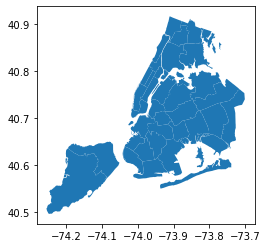

In [26]:
# plot all geometry polygons
ngbhoods.plot();

Just like with different types of maps, the two projections are similar and recognizable as the same area of land, but not identical.

Next, let's take a look at the regular pandas DataFrame containing our taxi trip data. You'll notice that this DataFrame also contains geographic information in the pickup_longitude/latitude and dropoff_longitude/latitude columns. 

In [27]:
df.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2012-01-10 23:55:50,2012-01-11 00:03:39,1,1.7,-73.994693,40.725031,1,N,-73.975951,40.730781,CRD,6.9,0.5,0.5,1.0,0.0,8.9
1,CMT,2012-01-11 19:18:25,2012-01-11 19:26:10,1,1.1,-73.987955,40.752947,1,N,-73.994532,40.761040,CSH,6.1,1.0,0.5,0.0,0.0,7.6


Calling type() on one of these values, however, reveals them to be regular numpy floats:

In [28]:
type(df.pickup_latitude[0])

numpy.float64

Calling .plot() on the latitude and longitude columns does not give us a meaningful spatial representation. Neither does calling .plot() on the entire DataFrame:

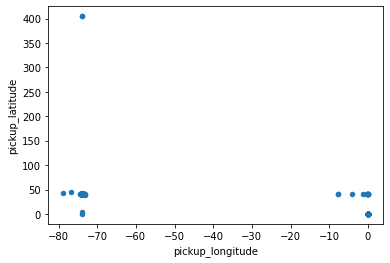

In [29]:
df.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude");

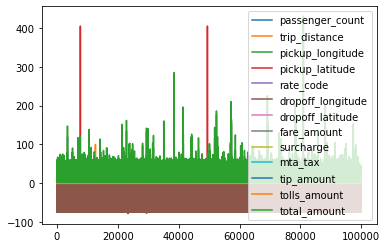

In [30]:
df.plot();

Let's convert df into a GeoPandas GeoDataFrame by converting the separate pickup_longitude and pickup_latitude columns into a single geometry column containing shapely Point data:

In [31]:
from shapely.geometry import Point

# turn taxi_df into geodataframe
taxi_gdf = gpd.GeoDataFrame(
    df,
    crs="EPSG:4326",
    geometry=[Point(xy) for xy in zip(df["pickup_longitude"], df["pickup_latitude"])],
)

Take a look at the first 3 rows:

In [32]:
taxi_gdf.head(3)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry
0,CMT,2012-01-10 23:55:50,2012-01-11 00:03:39,1,1.7,-73.994693,40.725031,1,N,-73.975951,40.730781,CRD,6.9,0.5,0.5,1.00,0.0,8.90,POINT (-73.99469 40.72503)
1,CMT,2012-01-11 19:18:25,2012-01-11 19:26:10,1,1.1,-73.987955,40.752947,1,N,-73.994532,40.761040,CSH,6.1,1.0,0.5,0.00,0.0,7.60,POINT (-73.98795 40.75295)
2,CMT,2012-01-11 19:19:19,2012-01-11 19:48:15,2,18.0,-73.783093,40.648550,2,N,-73.996134,40.747624,CRD,45.0,0.0,0.5,10.06,4.8,60.36,POINT (-73.78309 40.64855)


We now have a GeoDataFrame with a dedicated geometry column.

Before we continue on to our spatial join, let's drop some dead weight by removing columns we are no longer interested in:

In [33]:
# drop lat/long columns
taxi_gdf = taxi_gdf.drop(
    columns=[
        "pickup_longitude",
        "pickup_latitude",
        "dropoff_longitude",
        "dropoff_latitude",
        "vendor_id",
        "rate_code",
        "store_and_fwd_flag",
        "mta_tax",
    ]
)
taxi_gdf.head(3)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,geometry
0,2012-01-10 23:55:50,2012-01-11 00:03:39,1,1.7,CRD,6.9,0.5,1.00,0.0,8.90,POINT (-73.99469 40.72503)
1,2012-01-11 19:18:25,2012-01-11 19:26:10,1,1.1,CSH,6.1,1.0,0.00,0.0,7.60,POINT (-73.98795 40.75295)
2,2012-01-11 19:19:19,2012-01-11 19:48:15,2,18.0,CRD,45.0,0.0,10.06,4.8,60.36,POINT (-73.78309 40.64855)


Now that both of your datasets have geometry columns you can perform a spatial join.

Perform a left spatial join with taxi_gdf as the left_df and nghboohds as the right_df. Setting the predicate keyword to 'within' will join points in the left_df to polygons from the right_df they are located within:

In [34]:
%%timeit
# perform spatial join
gpd.sjoin(
    taxi_gdf,
    ngbhoods,
    how="left",
    predicate="within",
)

77.8 ms ± 3.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
joined = gpd.sjoin(
    taxi_gdf,
    ngbhoods,
    how="left",
    predicate="within",
)

In [36]:
# drop index column
joined = joined.drop(columns=["index_right"])

# rename columns
joined.rename(
    columns={"FIRST_UHF_": "pickup_ngbhood_name", "UHF_CODE": "pickup_ngbhood_id"},
    inplace=True,
)
joined.head(3)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,geometry,pickup_ngbhood_name,pickup_ngbhood_id
0,2012-01-10 23:55:50,2012-01-11 00:03:39,1,1.7,CRD,6.9,0.5,1.00,0.0,8.90,POINT (-73.99469 40.72503),Chelsea - Village,306308.0
1,2012-01-11 19:18:25,2012-01-11 19:26:10,1,1.1,CSH,6.1,1.0,0.00,0.0,7.60,POINT (-73.98795 40.75295),Chelsea - Village,306308.0
2,2012-01-11 19:19:19,2012-01-11 19:48:15,2,18.0,CRD,45.0,0.0,10.06,4.8,60.36,POINT (-73.78309 40.64855),None,0.0


Now that you've performed the spatial join, you can analyse spatial patterns in the data.

For example, you can run a groupby that aggregates the mean trip_distance per pickup neighborhood:

In [37]:
res = joined.groupby("pickup_ngbhood_name").trip_distance.mean()
res

pickup_ngbhood_name
Bayside - Meadows                       2.602500
Bedford Stuyvesant - Crown Heights      4.050441
Bensonhurst - Bay Ridge                 2.030000
Borough Park                            1.692174
Canarsie - Flatlands                    4.000000
Central Harlem - Morningside Heights    3.218552
Chelsea - Village                       2.364981
Coney Island - Sheepshead Bay           2.878889
Downtown  - Heights - Slope             3.855033
East Flatbush - Flatbush                5.969412
East Harlem                             2.695544
East New York                           3.833333
Flushing - Clearview                    5.330000
Fordham - Bronx Park                    4.460000
Greenpoint                              3.140287
Jamaica                                 6.854286
Kingsbridge - Riverdale                 0.950000
Long Island City - Astoria              3.716635
Northeast Bronx                         1.475000
Northern SI                             3.114000


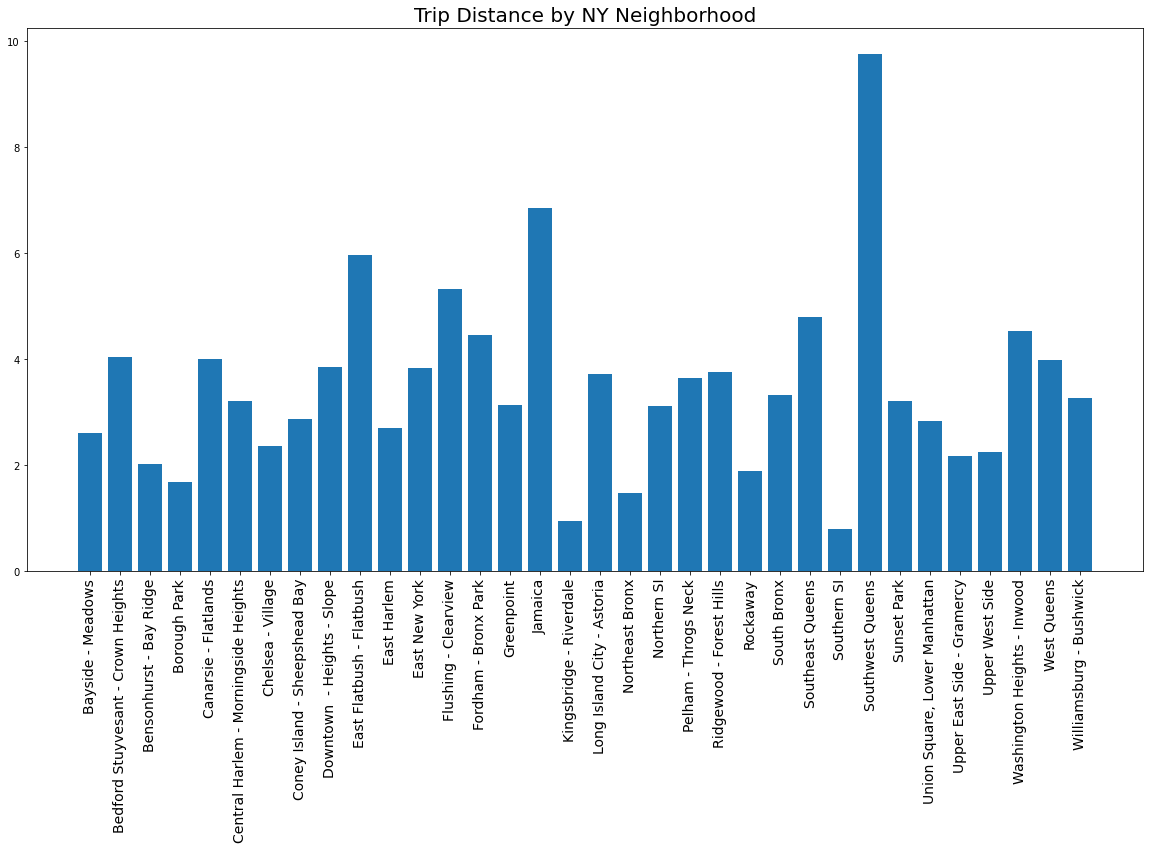

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
TimeoutError: [Errno 60] Operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/rpelgrim/mambaforge/envs/dask-dataframe/

In [53]:
fig,ax = plt.subplots(figsize=[20,10])
plt.bar(x=res.index, height=res)
plt.xticks(rotation=90, fontsize=14)
plt.title('Trip Distance by NY Neighborhood', fontsize=20)
plt.savefig("trip-distance-by-ngbhood.png");

## Spatial Join: Spatialpandas
You can also perform a spatial join in Python using the spatialpandas library. The spatialpandas library provides vectorized spatial and geometric operations using numba. It has some overlap in functionality with GeoPandas but the main distinction is that spatialpandas is focused on geometric rather than geospatial use-cases; it has no understanding of where points or shapes might be located on the surface of the Earth. This allows spatialpandas to free itself from many of the geographical package dependencies (which make it easier and lighter to install) but also reduces the range of applications.

Let's repeat the workflow we did above, but now with spatialpandas.

There is no way of directly loading a shapefile into spatialpandas, so we will convert our GeoPandas GeoDataFrame ngbhoods into a spatialpandas GeoDataFrame instead:

In [27]:
from spatialpandas import GeoDataFrame, GeoSeries

In [28]:
ngbhoods_sp = GeoDataFrame(ngbhoods)
ngbhoods_sp.head(3)

/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/polygon.py:41: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  exterior = np.asarray(shape.exterior.ctypes)
/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/multipolygon.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in shape:


,geometry,FIRST_UHF_,UHF_CODE
0,"MultiPolygon([[[-73.8779313565267, 40.90556327...",Kingsbridge - Riverdale,101.0
1,"MultiPolygon([[[-73.85252590936993, 40.9098462...",Northeast Bronx,102.0
2,"MultiPolygon([[[-73.85626847312932, 40.8831498...",Fordham - Bronx Park,103.0


In [29]:
type(ngbhoods_sp)

spatialpandas.geodataframe.GeoDataFrame

<AxesSubplot:>

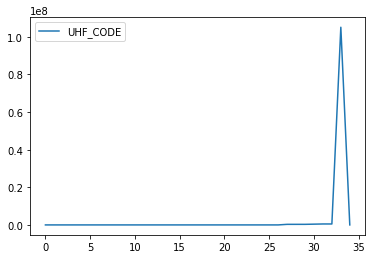

In [30]:
ngbhoods_sp.plot()

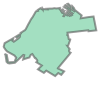

In [35]:
ngbhoods_sp.geometry[5].to_shapely()

### Convert Taxi Data to Spatialpandas Geometry

In [36]:
from spatialpandas.geometry import PointArray

Spatialpandas works slightly differently. It is more flexible and allows you to construct different kinds of geometries.

We'll create Point Arrays from the pickup longitude and latitude columns and then add that PointArray column to our df:

In [23]:
# turn pickup lat/long into spatialpandas geometry
pickups = df[["pickup_longitude", "pickup_latitude"]]
pickup_points = PointArray(pickups)
pickup_points

<PointArray>
[        Point([-73.991957, 40.721567]),
          Point([-73.982102, 40.73629]),
         Point([-74.002587, 40.739748]),
         Point([-73.974267, 40.790955]),
          Point([-74.00158, 40.719382]),
         Point([-73.989806, 40.735006]),
 Point([-73.98404999999998, 40.743544]),
         Point([-73.992635, 40.748362]),
          Point([-73.96969, 40.749244]),
         Point([-73.955173, 40.783044]),
 ...
          Point([-73.96978, 40.753049]),
         Point([-73.952954, 40.776361]),
         Point([-73.954578, 40.773146]),
                      Point([0.0, 0.0]),
         Point([-73.965461, 40.765825]),
 Point([-73.98531199999998, 40.763286]),
         Point([-73.958948, 40.780668]),
         Point([-73.984502, 40.728968]),
 Point([-73.99223499999998, 40.749299]),
         Point([-74.008144, 40.723281])]
Length: 1000000, dtype: point[float64]

In [24]:
# create GeoDataFrame from PointArray
taxi_gdf_sp = GeoDataFrame(
    {
        "pickup_geo": pickup_points,
    }
)

In [25]:
# drop numeric geo data from df
df2 = df.drop(
    columns=[
        "dropoff_longitude",
        "dropoff_latitude",
        "pickup_longitude",
        "pickup_latitude",
    ],
)

In [26]:
# join dataframes
taxi_gdf_sp = taxi_gdf_sp.merge(
    df2,
    how="left",
    left_index=True,
    right_index=True,
)

/Users/rpelgrim/mambaforge/envs/dask-dataframe/lib/python3.9/site-packages/spatialpandas/geometry/point.py:31: ShapelyDeprecationWarning: Accessing the 'ctypes' attribute is deprecated, and will not be possible any more in Shapely 2.0
  return np.asarray(shape.ctypes)


In [27]:
taxi_gdf_sp.head(3)

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.0,9.40,"Point([-73.991957, 40.721567])"
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.0,14.60,"Point([-73.982102, 40.73629])"
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.0,28.44,"Point([-74.002587, 40.739748])"


Now we're ready to perform our spatial join:

In [28]:
from spatialpandas import sjoin

In [33]:
import spatialpandas

spatialpandas.__version__

'0.4.3'

In [32]:
%%time
# execute spatial join
# first run: 6.41s
# 2nd run: 3.34s
# 3rd run: 3.32s
# 4th run: 3.33s
sjoin(
    taxi_gdf_sp,
    ngbhoods_sp,
    how="left",
    op="intersects",
)

CPU times: user 6.82 s, sys: 2.69 s, total: 9.51 s
Wall time: 3.33 s


,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry,index_right,FIRST_UHF_,UHF_CODE
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.0,9.40,"Point([-73.991957, 40.721567])",29.0,"Union Square, Lower Manhattan",309310.0
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.0,14.60,"Point([-73.982102, 40.73629])",27.0,Upper East Side - Gramercy,305307.0
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.0,28.44,"Point([-74.002587, 40.739748])",28.0,Chelsea - Village,306308.0
3,"Point([-73.974267, 40.790955])",DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,NaN,NaN,CREDIT,14.9,0.5,NaN,3.05,0.0,18.45,"Point([-73.974267, 40.790955])",18.0,Upper West Side,304.0
4,"Point([-74.00158, 40.719382])",DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,NaN,NaN,CASH,3.7,0.0,NaN,0.00,0.0,3.70,"Point([-74.00158, 40.719382])",28.0,Chelsea - Village,306308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,"Point([-73.98531199999998, 40.763286])",CMT,2009-01-14 19:43:31,2009-01-14 19:48:08,1,0.60,NaN,NaN,Cash,5.5,0.0,NaN,0.00,0.0,5.50,"Point([-73.98531199999998, 40.763286])",28.0,Chelsea - Village,306308.0
999996,"Point([-73.958948, 40.780668])",CMT,2009-01-12 16:36:30,2009-01-12 16:40:43,1,0.80,NaN,NaN,Credit,5.9,0.0,NaN,1.00,0.0,6.90,"Point([-73.958948, 40.780668])",27.0,Upper East Side - Gramercy,305307.0
999997,"Point([-73.984502, 40.728968])",CMT,2009-01-12 14:16:57,2009-01-12 14:28:02,1,4.70,NaN,NaN,Credit,12.9,0.0,NaN,1.93,0.0,14.83,"Point([-73.984502, 40.728968])",29.0,"Union Square, Lower Manhattan",309310.0
999998,"Point([-73.99223499999998, 40.749299])",CMT,2009-01-22 11:21:35,2009-01-22 11:37:06,1,1.50,NaN,NaN,Cash,9.3,0.0,NaN,0.00,0.0,9.30,"Point([-73.99223499999998, 40.749299])",28.0,Chelsea - Village,306308.0


In [ ]:
# execute spatial join
joined_sp = sjoin(
    taxi_gdf_sp,
    ngbhoods_sp,
    how="left",
    op="intersects",
)

In [78]:
joined_sp

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry,index_right,FIRST_UHF_,UHF_CODE
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.00,9.40,"Point([-73.991957, 40.721567])",29.0,"Union Square, Lower Manhattan",309310.0
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.00,14.60,"Point([-73.982102, 40.73629])",27.0,Upper East Side - Gramercy,305307.0
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.00,28.44,"Point([-74.002587, 40.739748])",28.0,Chelsea - Village,306308.0
3,"Point([-73.974267, 40.790955])",DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,NaN,NaN,CREDIT,14.9,0.5,NaN,3.05,0.00,18.45,"Point([-73.974267, 40.790955])",18.0,Upper West Side,304.0
4,"Point([-74.00158, 40.719382])",DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,NaN,NaN,CASH,3.7,0.0,NaN,0.00,0.00,3.70,"Point([-74.00158, 40.719382])",28.0,Chelsea - Village,306308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Point([-73.997167, 40.737425])",VTS,2009-01-03 21:33:00,2009-01-03 21:39:00,1,1.10,NaN,NaN,CASH,5.3,0.5,NaN,0.00,0.00,5.80,"Point([-73.997167, 40.737425])",28.0,Chelsea - Village,306308.0
9996,"Point([-73.96221199999998, 40.779117])",VTS,2009-01-03 19:04:00,2009-01-03 19:19:00,5,2.64,NaN,NaN,CASH,10.1,0.0,NaN,0.00,0.00,10.10,"Point([-73.96221199999998, 40.779117])",34.0,None,0.0
9997,"Point([-73.873022, 40.774053])",VTS,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,NaN,NaN,CASH,24.1,0.0,NaN,0.00,4.15,28.25,"Point([-73.873022, 40.774053])",34.0,None,0.0
9998,"Point([-73.984955, 40.756653])",VTS,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,NaN,NaN,Credit,11.3,1.0,NaN,2.00,0.00,14.30,"Point([-73.984955, 40.756653])",28.0,Chelsea - Village,306308.0


In [81]:
joined_sp

,pickup_geo,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,geometry,index_right,FIRST_UHF_,UHF_CODE
0,"Point([-73.991957, 40.721567])",VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,NaN,NaN,CASH,8.9,0.5,NaN,0.00,0.00,9.40,"Point([-73.991957, 40.721567])",29.0,"Union Square, Lower Manhattan",309310.0
1,"Point([-73.982102, 40.73629])",VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,NaN,NaN,Credit,12.1,0.5,NaN,2.00,0.00,14.60,"Point([-73.982102, 40.73629])",27.0,Upper East Side - Gramercy,305307.0
2,"Point([-74.002587, 40.739748])",VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,NaN,NaN,Credit,23.7,0.0,NaN,4.74,0.00,28.44,"Point([-74.002587, 40.739748])",28.0,Chelsea - Village,306308.0
3,"Point([-73.974267, 40.790955])",DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,NaN,NaN,CREDIT,14.9,0.5,NaN,3.05,0.00,18.45,"Point([-73.974267, 40.790955])",18.0,Upper West Side,304.0
4,"Point([-74.00158, 40.719382])",DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,NaN,NaN,CASH,3.7,0.0,NaN,0.00,0.00,3.70,"Point([-74.00158, 40.719382])",28.0,Chelsea - Village,306308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Point([-73.997167, 40.737425])",VTS,2009-01-03 21:33:00,2009-01-03 21:39:00,1,1.10,NaN,NaN,CASH,5.3,0.5,NaN,0.00,0.00,5.80,"Point([-73.997167, 40.737425])",28.0,Chelsea - Village,306308.0
9996,"Point([-73.96221199999998, 40.779117])",VTS,2009-01-03 19:04:00,2009-01-03 19:19:00,5,2.64,NaN,NaN,CASH,10.1,0.0,NaN,0.00,0.00,10.10,"Point([-73.96221199999998, 40.779117])",34.0,None,0.0
9997,"Point([-73.873022, 40.774053])",VTS,2009-01-03 09:54:00,2009-01-03 10:17:00,2,9.06,NaN,NaN,CASH,24.1,0.0,NaN,0.00,4.15,28.25,"Point([-73.873022, 40.774053])",34.0,None,0.0
9998,"Point([-73.984955, 40.756653])",VTS,2009-01-07 19:56:00,2009-01-07 20:04:00,1,3.02,NaN,NaN,Credit,11.3,1.0,NaN,2.00,0.00,14.30,"Point([-73.984955, 40.756653])",28.0,Chelsea - Village,306308.0


Looks like this worked.

Geopandas was faster and required less steps. When working with datasets that are small enough to fit into memory (pandas DataFrames), generally use GeoPandas. Unless you need some of the specific functionality of spatialpandas.

## Spatial Join: at scale with Dask and Geopandas
GeoPandas is great. But because it simply extends the pandas architecture, it also inherits the same scalability that pandas has. pandas processes data on a single core. This means you are limited in the amount of data you can process at once.

You can use Dask to parallelize any Python code. This means it's possible to create parallel version of most libraries using Dask. You could think of Dask as an all-round engine for parallelism in Python: plug into your existing car and scale up performance.

Dask DataFrames allow you to scale your pandas workflows. Dask DataFrames overcome two key limitations of pandas:
- pandas cannot run on datasets larger than memory
- pandas only uses one core when running analyses, which can be slow

Dask DataFrames are designed to overcome these pandas limitations. They can be run on datasets that are larger than memory and use all cores by default for fast execution.

Dask-geopandas scales Geopandas to larger-than-memory datasets using out-of-core computations. Since GeoPandas is an extension to the pandas DataFrame, the same way Dask scales pandas can also be applied to GeoPandas.

Let's see this in action.

We're going to be working at scale now with the data for the five-year period from 2009-2013. This data totals ~120GB on disk. 

Most personal computers don't have the memory resources to process a dataset of that size locally:

In [ ]:
df = pd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009-2013/*",
)

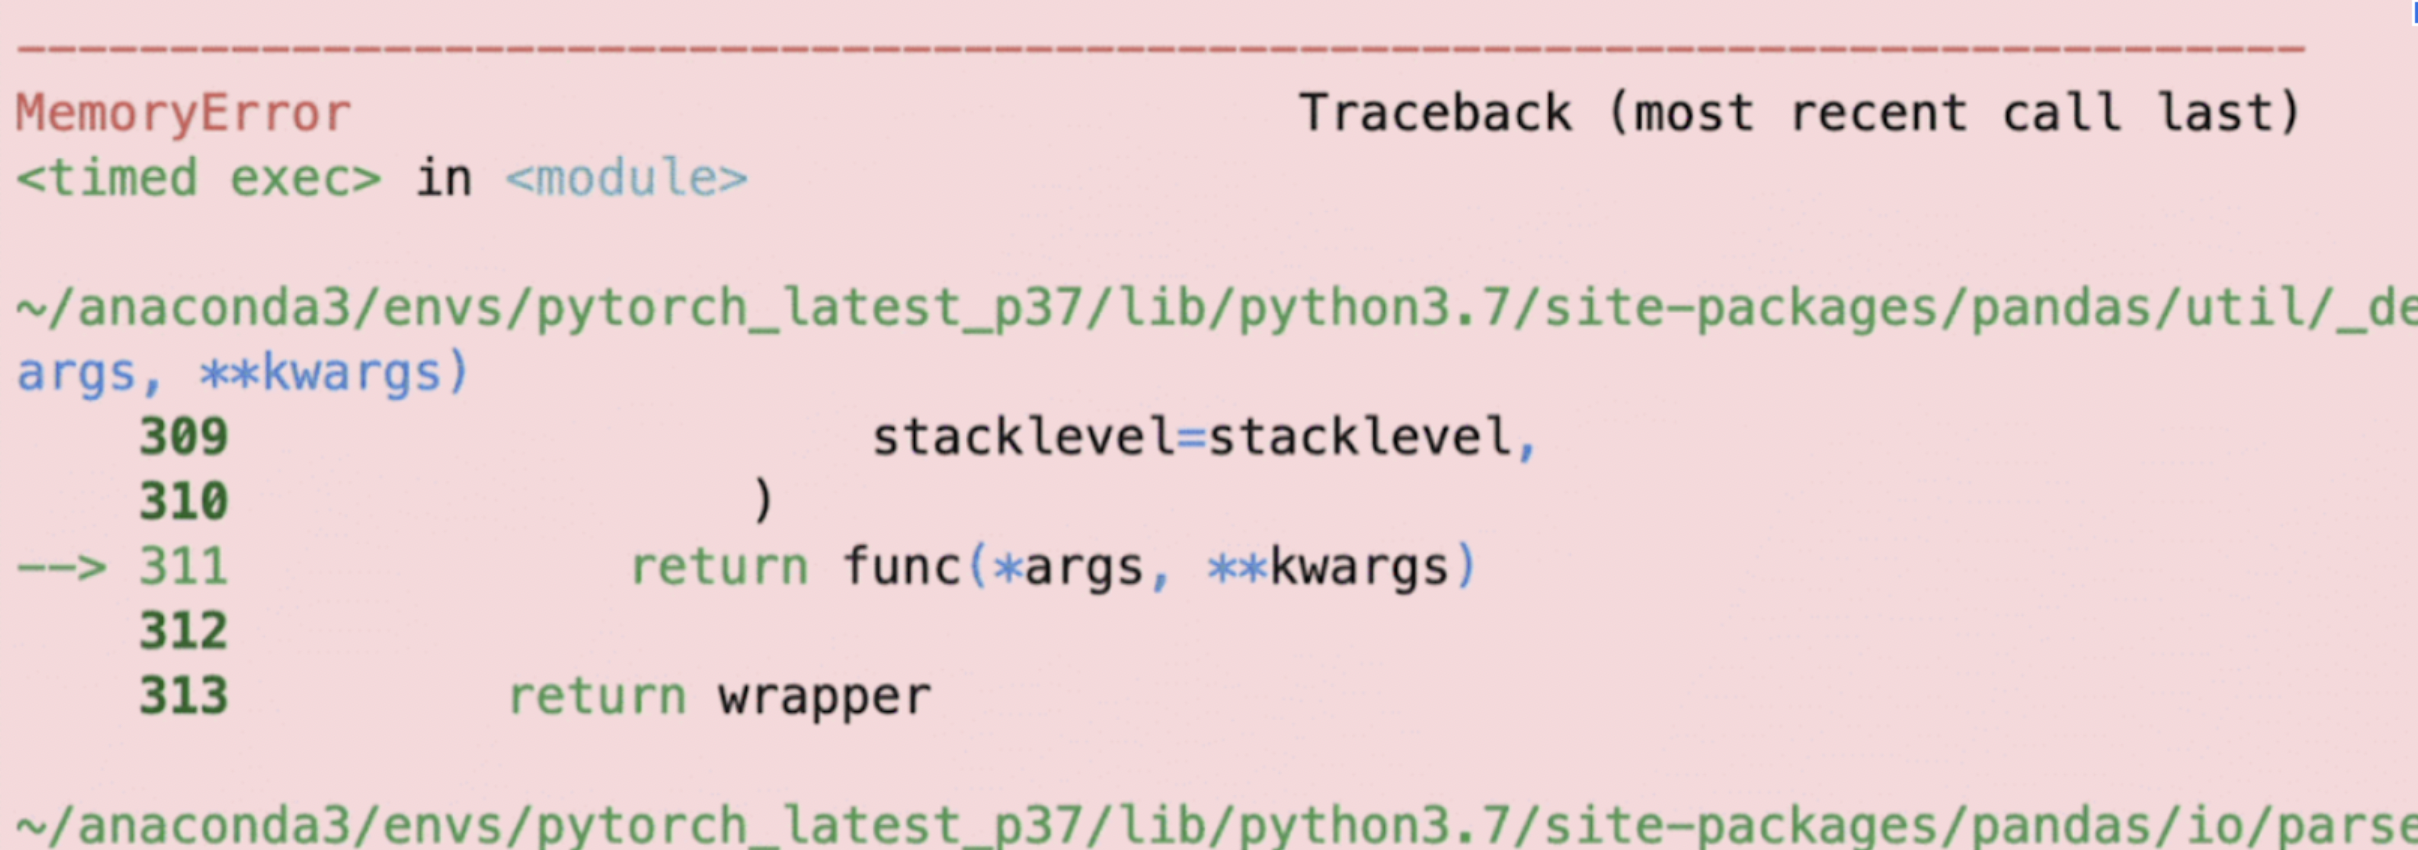

We'll need some extra computing power to run this analysis. Let's scale out to a Dask cluster with Coiled.

We'll spin up a cluster of 50 workers with 16GiB of RAM each. That should be plenty to comfortably process the 120GB dataset we'll be working with.

In [1]:
from coiled.v2 import Cluster

cluster = Cluster(
    name="spatial-join",
    software="coiled-examples/spatial-join",
    n_workers=50,
    worker_memory="16Gib",
)

╭───────────────────────────────────────── Coiled Cluster ─────────────────────────────────────────╮
│                     ]8;id=559487;https://cloud.coiled.io/rrpelgrim/clusters/24759/details\https://cloud.coiled.io/rrpelgrim/clusters/24759/details]8;;\                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────── Overview ───────────────────╮╭──────────────── Configuration ─────────────────╮
│                                                ││                                                │
│ Cluster Name: spatial-join                     ││ Region: us-east-1                              │
│                                                ││                                                │
│ Cluster Status: ready                          ││ Scheduler Instance Type: t3.medium             │
│                                                ││                                                │
│ Scheduler Status: started                      ││ Worker Instance Type(s): t3a.xlarge (50)       │
│                                                ││                                                │
│ Dashboard Address: ]8;id=955975;http://44.197.118.219:8787\http://44.197.118.219:8787]8;;\  ││ Workers Requested: 50                          │
│                                                ││                                                │
│                                                ││                                                │
╰────────────────────────────────────────────────╯╰────────────────────────────────────────────────╯
╭─────────────────────────────────── (2022/05/10 14:20:02 CEST) ───────────────────────────────────╮
│                                                                                                  │
│                                        All workers ready.                                        │
│                                                                                                  │
│                                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Now connect your local Dask session to the Coiled cluster so that all future Dask computations are run in the cloud instead of locally:

In [2]:
from distributed import Client
client = Client(cluster)

Now load the full 120GB dataset into a Dask DataFrame:

In [21]:
import dask.dataframe as dd

ddf = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009-2013/*",
    engine="pyarrow",
    storage_options={"anon": True},
)

Your data is now loaded into a Dask DataFrame. Dask follows the pandas API you're familiar with, so working with Dask DataFrame will look and feel a lot like pandas. You can call familiar methods like head() and perform groupby aggregations:

In [22]:
ddf.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,-73.993803,40.695922,CASH,8.9,0.5,0.00,0.0,9.40
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,-73.955850,40.768030,Credit,12.1,0.5,2.00,0.0,14.60
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,-73.869983,40.770225,Credit,23.7,0.0,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,-73.996558,40.731849,CREDIT,14.9,0.5,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,-74.008378,40.720350,CASH,3.7,0.0,0.00,0.0,3.70


In [30]:
ddf.groupby("passenger_count").tip_amount.mean().compute()

passenger_count
0      0.810627
1      0.988850
2      0.892365
3      0.811833
4      0.699543
         ...   
66     1.500000
177    1.000000
247    2.300000
249    0.000000
254    0.000000
Name: tip_amount, Length: 62, dtype: float64

Note that Dask operates using lazy evaluation which means you need to explicitly trigger computations using a call to compute(). Read The Beginner's Guide to Distributed Computing to learn more about these key concepts.

Next, let's import the health data we have available at the NYC Neighbourhood level:

In [23]:
import geopandas as gpd

In [24]:
health = gpd.read_file(
    "/Users/rpelgrim/Desktop/data/nyc/nyc-communityhealth-shapefiles/CHS_2009_DOHMH_2010B/CHS_2009_DOHMH_2010B.shp"
)
health = health[["FIRST_UHF_", "UHF_CODE", "geometry", "wkwork2", "exercs2", "depres2"]]
health = health[:34]
health = health.rename(columns={"FIRST_UHF_": "nhbd_name", "UHF_CODE": "nhbd_id"})
health = health.to_crs(epsg=4326)

health.head(3)

,nhbd_name,nhbd_id,geometry,wkwork2,exercs2,depres2
0,Kingsbridge - Riverdale,101.0,"POLYGON ((-73.87793 40.90556, -73.87859 40.903...",65.5,72.2,15.6
1,Northeast Bronx,102.0,"POLYGON ((-73.85253 40.90985, -73.85235 40.909...",61.9,79.2,12.2
2,Fordham - Bronx Park,103.0,"POLYGON ((-73.85627 40.88315, -73.85666 40.882...",60.5,62.9,13.8


We now have the two datasets we want to combine: a small GeoPandas DataFrame containing the health data at neighborhood level and the 120GB of taxi cab data loaded into a Dask DataFrame.

Dask parallelizes Python code. It generally does this by turning large operations into smaller chunks that can be processed in parallel. This parallelism gives you two important benefits: you can perform computations faster and on datasets that are larger than your local memory. 

In a Dask DataFrame these smaller chunks are called partitions. Each Dask DataFrame partition is a pandas DataFrame. 

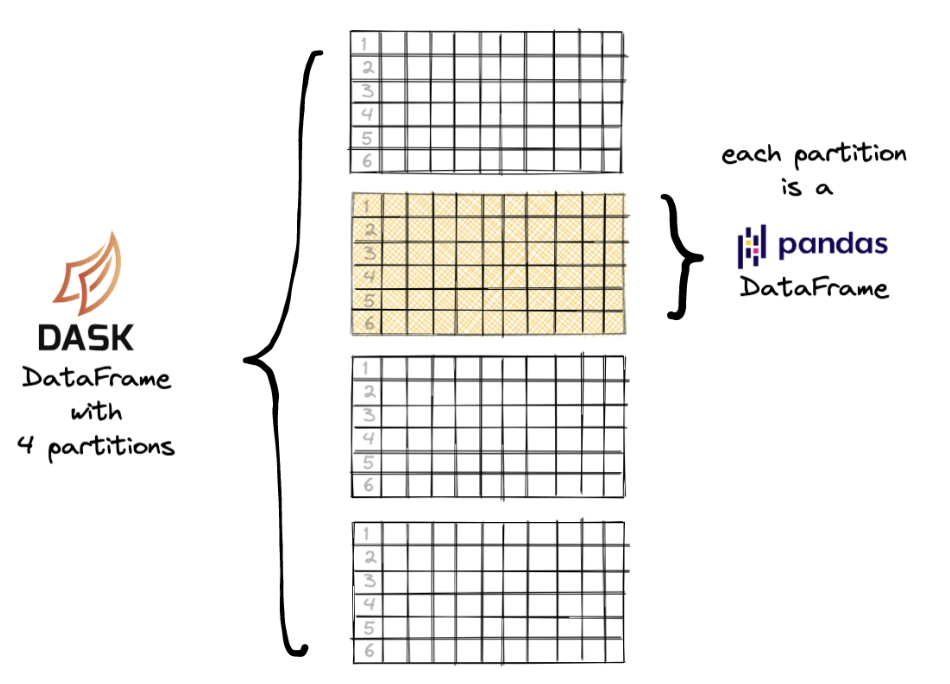

First, let's convert our Dask DataFrame into a Dask-GeoPandas GeoDataFrame:

In [25]:
import dask_geopandas

ddf = ddf.set_geometry(
    dask_geopandas.points_from_xy(ddf, "pickup_longitude", "pickup_latitude"),
)

In [26]:
ddf.head(3)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,geometry
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,-73.993803,40.695922,CASH,8.9,0.5,0.00,0.0,9.40,POINT (-73.99196 40.72157)
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,-73.955850,40.768030,Credit,12.1,0.5,2.00,0.0,14.60,POINT (-73.98210 40.73629)
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,-73.869983,40.770225,Credit,23.7,0.0,4.74,0.0,28.44,POINT (-74.00259 40.73975)


Our Dask DataFrame now has a `geometry` column.

Next, we'll have to set the CRS to match that of the `health` GeoDataFrame. The map_partitions() method allows you to map any Python function over all of the partitions in a Dask DataFrame. The function that is passed to map_partitions should take a pandas DataFrame as input.

In [27]:
ddf = ddf.map_partitions(lambda x: x.set_crs(epsg="4326"))

Before we perform the spatial join on our Coiled cluster, we need to make sure that all of the workers in our cluster have a copy of the health data. This is currently not the case because we loaded it into a regular GeoPandas DataFrame; it's sitting in local memory and our cloud cluster does not have access to it.

Scatter the health GeoDataFrame to send a copy to all workers in your cluster:

In [28]:
client.scatter(health)

<Future: finished, type: geopandas.geodataframe.GeoDataFrame, key: GeoDataFrame-6264c1fd87c2964206ed00e0dd09bc5a>

Now perform the spatial join:

In [29]:
%%time
joined1 = ddf.sjoin(health, predicate="within")

CPU times: user 23.4 ms, sys: 2.26 ms, total: 25.7 ms
Wall time: 24.2 ms


Dask holds off on actually performing the join until we explicitly call compute() on a result downstream.

Let's perform a groupby on the joined data:

In [30]:
%%time
joined1.groupby("nhbd_name").tip_amount.mean().compute()

CPU times: user 701 ms, sys: 49.6 ms, total: 751 ms
Wall time: 1min 30s


nhbd_name
Bayside - Meadows                       1.523970
Bedford Stuyvesant - Crown Heights      1.170296
Bensonhurst - Bay Ridge                 1.043649
Borough Park                            0.970536
Canarsie - Flatlands                    1.027048
Central Harlem - Morningside Heights    1.014322
Chelsea - Village                       0.875355
Coney Island - Sheepshead Bay           0.949707
Downtown  - Heights - Slope             1.246141
East Flatbush - Flatbush                0.928637
East Harlem                             0.798915
East New York                           1.082279
Flushing - Clearview                    0.914412
Fordham - Bronx Park                    0.898696
Greenpoint                              1.172317
Jamaica                                 2.158574
Kingsbridge - Riverdale                 1.054347
Long Island City - Astoria              0.909555
Northeast Bronx                         0.971505
Northern SI                             1.056143
Pelham - T

You can speed up Dask-GeoPandas spatial joins by calculating the spatial partitions before performing the join. This allows Dask to take shortcuts while doing the join and will significantly reduce your processing time.

Let's see this in action:

In [31]:
%%time
ddf.calculate_spatial_partitions()

CPU times: user 1.29 s, sys: 137 ms, total: 1.43 s
Wall time: 41.3 s


And then perform the spatial join again:

In [32]:
joined2 = ddf.sjoin(health, predicate="within")

In [33]:
%%time
joined2.groupby("nhbd_name").tip_amount.mean().compute()

CPU times: user 643 ms, sys: 46.8 ms, total: 690 ms
Wall time: 1min 28s


nhbd_name
Bayside - Meadows                       1.523970
Bedford Stuyvesant - Crown Heights      1.170296
Bensonhurst - Bay Ridge                 1.043649
Borough Park                            0.970536
Canarsie - Flatlands                    1.027048
Central Harlem - Morningside Heights    1.014322
Chelsea - Village                       0.875355
Coney Island - Sheepshead Bay           0.949707
Downtown  - Heights - Slope             1.246141
East Flatbush - Flatbush                0.928637
East Harlem                             0.798915
East New York                           1.082279
Flushing - Clearview                    0.914412
Fordham - Bronx Park                    0.898696
Greenpoint                              1.172317
Jamaica                                 2.158574
Kingsbridge - Riverdale                 1.054347
Long Island City - Astoria              0.909555
Northeast Bronx                         0.971505
Northern SI                             1.056143
Pelham - T

Calculating the spatial partitions took 41.3s and gave us a 2s speed-up. This will only become a net win if you are planning to run multiple computations on the joined dataset. You'll have to consider whether or not to calculate the spatial partitions before the spatial join based on your specific use case. 

Now that we have the joined dataset containing taxi trips and public health data, let's look at walk-to-work percentage in neighbourhoods with highest taxi pickups:

We'll be using the map_partitions method to perform our spatial join. This method allows you to map any Python function over all of the partitions in a Dask DataFrame. The function that is passed to map_partitions should take a pandas DataFrame as input.

Fortunately, we just wrote code that operates on regular GeoPandas GeoDataFrames in the previous section. With some tweaks, we'll be able to map this code over all the partitions in our Dask DataFrame:

In [19]:
from shapely.geometry import Point
import numpy as np

# define function that will be mapped over each partition
def sjoin_map(df, lon_var, lat_var):
    try:
        # turn partition into a geopandas dataframe
        gdf = gpd.GeoDataFrame(
            df,
            crs="EPSG:4326",
            geometry=[Point(xy) for xy in zip(df[lon_var], df[lat_var])],
        )

        # spatial join health data to partition
        gdf = gpd.sjoin(
            gdf,
            health,
            how="left",
            predicate="within",
        )

    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
        return series
        
    return gdf

Let's define the function that will set the Coordinate Reference System and then perform the spatial join. Notice that the spatial join code in this function is identical to the regular GeoPandas code we ran above, we're simply mapping this function over all the partitions (GeoPandas DataFrames) in our Dask DataFrame.

In [11]:
# def sjoin_map(df):
#     # set coordinate reference system
#     df = df.set_crs(epsg="4326")

#     # spatial join health data to each partition
#     df = gpd.sjoin(
#         df,
#         health,
#         how="left",
#         predicate="within",
#     )

#     return df

Before we perform the spatial join on our Coiled cluster, we need to make sure that all of the workers in our cluster have a copy of the health data. This is currently not the case because we loaded it into a regular GeoPandas DataFrame; it's sitting in local memory and our cloud cluster does not have access to it.

Scatter the health GeoDataFrame to send a copy to all workers in your cluster:

In [9]:
client.scatter(health)

<Future: finished, type: geopandas.geodataframe.GeoDataFrame, key: GeoDataFrame-2196910c8c4a53c5b425d26413493e72>

Now perform the spatial join with a call to map_partitions():

In [20]:
joined = ddf.map_partitions(
    sjoin_map,
    "pickup_longitude",
    "pickup_latitude",
)

In [21]:
joined.head(3)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,...,tip_amount,tolls_amount,total_amount,geometry,index_right,nhbd_name,nhbd_id,wkwork2,exercs2,depres2
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,-73.993803,40.695922,CASH,...,0.00,0.0,9.40,POINT (-73.99196 40.72157),29.0,"Union Square, Lower Manhattan",309310.0,73.8,79.0,12.4
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,-73.955850,40.768030,Credit,...,2.00,0.0,14.60,POINT (-73.98210 40.73629),27.0,Upper East Side - Gramercy,305307.0,85.0,85.9,14.8
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,-73.869983,40.770225,Credit,...,4.74,0.0,28.44,POINT (-74.00259 40.73975),28.0,Chelsea - Village,306308.0,85.8,88.3,21.5


In [ ]:
%%time
joined.groupby("nhbd_name").tip_amount.mean().compute()

This way of performing the sjoin clearly works, but is very slow.

## Next
- What is Dask
- 5 Common Mistakes
- Beginner's Guide to Distributed Computing